[INFO] Project root: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous

TOP-20
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ rank ┃ representation_family             ┃ embedding        ┃ mtr_model      ┃ augmentation ┃ rrmse  ┃
┣━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━┫
│ 1    │ augmented + frozen sentence + MTR │ e5_base          │ chain_ERCcv_lr │ A20          │ 0.6676 │
├──────┼───────────────────────────────────┼──────────────────┼────────────────┼──────────────┼────────┤
│ 2    │ augmented + frozen sentence + MTR │ e5_base          │ chain_ERCcv_lr │ A50          │ 0.6737 │
├──────┼───────────────────────────────────┼──────────────────┼────────────────┼──────────────┼────────┤
│ 3    │ augmented + frozen sentence + MTR │ e5_base          │ chain_ERCcv_lr │ A10          │ 0.6738 │
├──────┼───────────────────────────────────┼──────────────────┼─────────

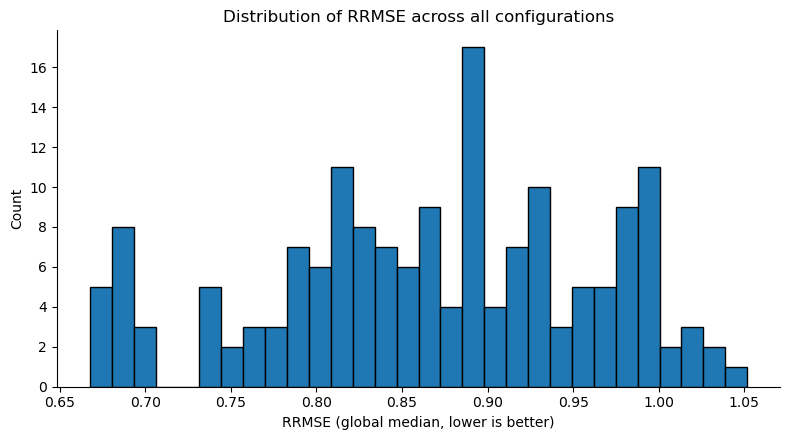

[PLOT] Distribution written → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/plots/rrmse_distribution.png


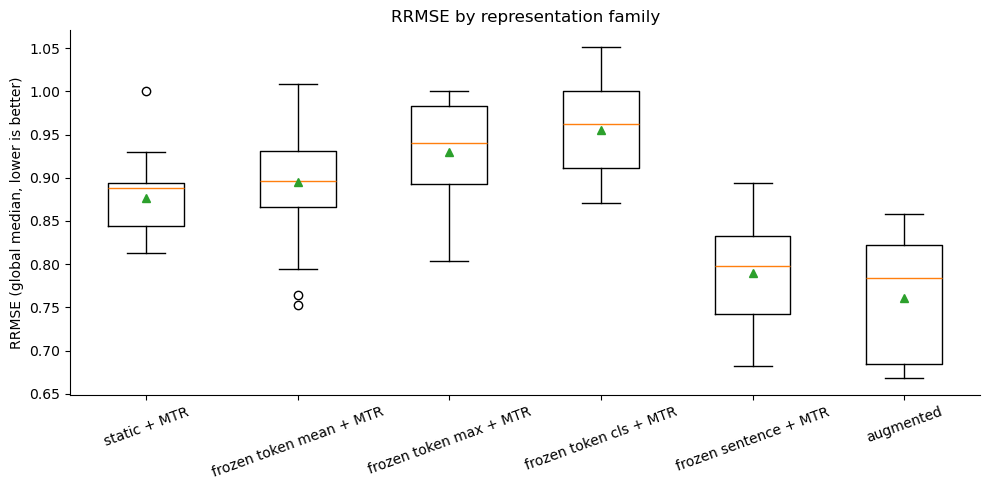

[PLOT] Per-family boxplot written → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/plots/rrmse_boxplot_by_family.png
[REPORT] Markdown saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/reports/leaderboard/leaderboard.md

Done. Elapsed 0.4s
Tables → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/results
Plots  → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/plots
Report → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/reports/leaderboard/leaderboard_report.md


In [16]:
"""
r_1_overall_leaderboard.py
───────────────────────────────────────────────────────────────────────────────
Overall leaderboard across:
  • Static word embeddings + MTR — Word2Vec, FastText (excluding 'mean' regressors).
  • Frozen transformers + MTR — token pooling (mean|max|cls) and sentence encoders.
  • Augmented students (e_3_student_scoring) — ONLY FULL (%K) variants (baseline excluded).
  • Optional: fine-tuned LoRA — if artifacts are present (reported as "fine-tuned LoRA").

Report prints + saves:
  a) Top-20 table (ranked by global median RRMSE).
  b) Full Leaderboard table (all rows, ranked).
  c) Breakdown table by family/subfamily (counts + best/mean/std).
  d) Distribution plot of RRMSE.
  e) Per-family boxplot (families; augmented aggregated).

Inputs (expected on disk):
- Static: outputs/a_static/results/baseline_{word2vec|fasttext}_loocv_rrmse.npy
- Frozen: outputs/b_frozen/results/*_loocv_rrmse.npy
- Augmented FULL: outputs/e_3_student_scoring/results/
  rrmse_perfold_{embedding}__{regressor}__{method}__pct{P}_K{K}__Mmax{M}__full.csv
- Optional fine-tuned: outputs/fine_tuned/results/*_loocv_rrmse.npy

Outputs:
- outputs/r_1_overall/results/top20.csv
- outputs/r_1_overall/results/full_leaderboard.csv
- outputs/r_1_overall/results/breakdown_family_subfamily.csv
- outputs/r_1_overall/plots/rrmse_distribution.png
- outputs/r_1_overall/plots/rrmse_boxplot_by_family.png
- reports/leaderboard/leaderboard_report.md (+ copies of the two plots)
"""

# ────────────────────────────────────────────
# Imports
# ────────────────────────────────────────────

import os
import re
import sys
import time
import shutil
import warnings
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", category=FutureWarning)

# ────────────────────────────────────────────
# Paths
# ────────────────────────────────────────────

def get_project_root(marker: str = "LICENSE") -> Path:
    """Walk up from CWD to find repo root (file marker present)."""
    cwd = Path.cwd().resolve()
    for cand in (cwd, *cwd.parents):
        if (cand / marker).is_file():
            return cand
    return cwd

ROOT = get_project_root()
print(f"[INFO] Project root: {ROOT}")

OUTPUTS_DIR = ROOT / "outputs"
A_STATIC_RES   = OUTPUTS_DIR / "a_static" / "results"
B_FROZEN_RES   = OUTPUTS_DIR / "b_frozen" / "results"
E3_RESULTS_DIR = OUTPUTS_DIR / "e_3_student_scoring" / "results"
FT_RES_DIR     = OUTPUTS_DIR / "fine_tuned" / "results"  # optional

R1_DIR      = OUTPUTS_DIR / "r_1_overall"
RESULTS_DIR = R1_DIR / "results"
PLOTS_DIR   = R1_DIR / "plots"
for p in (RESULTS_DIR, PLOTS_DIR):
    p.mkdir(parents=True, exist_ok=True)

REPORTS_DIR = ROOT / "reports" / "leaderboard"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────────────────────
# Settings / filters
# ────────────────────────────────────────────

REVIEW_MODE   = True

# Robust 'mean' regressor exclusion (token-aware; catches chain_ERCcv_mean, local_mean, global_mean, etc.)
_MEAN_TOKEN_RE = re.compile(r'(^|[_\W])mean($|[_\W])', re.IGNORECASE)
def is_excluded_mtr(model_name: str) -> bool:
    if model_name is None:
        return False
    return bool(_MEAN_TOKEN_RE.search(str(model_name)))

# ────────────────────────────────────────────
# Minimal IO helpers
# ────────────────────────────────────────────

def _load_rrmse_artifact(npy_path: Path) -> dict:
    """Return {model_name -> (folds x targets) array} from a saved .npy artifact."""
    arr = np.load(npy_path, allow_pickle=True)
    if isinstance(arr.item(), dict):
        return arr.item()
    raise ValueError(f"Unexpected artifact format in {npy_path.name}")

def discover_static_artifacts() -> dict:
    if not A_STATIC_RES.exists():
        return {}
    mapping = {}
    for f in A_STATIC_RES.glob("baseline_*_loocv_rrmse.npy"):
        emb = f.stem.replace("baseline_", "").replace("_loocv_rrmse", "")
        mapping[emb] = f
    return dict(sorted(mapping.items()))

def discover_frozen_artifacts() -> dict:
    if not B_FROZEN_RES.exists():
        return {}
    mapping = {}
    for f in B_FROZEN_RES.glob("*_loocv_rrmse.npy"):
        key = f.stem.replace("_loocv_rrmse", "")
        mapping[key] = f
    return dict(sorted(mapping.items()))

_E3_PAT = re.compile(
    r"^rrmse_perfold_(?P<emb>.+?)__(?P<reg>.+?)__(?P<meth>.+?)__pct(?P<pct>\d+)_K(?P<K>\d+)__Mmax(?P<M>\d+)__(?P<var>baseline|full)\.csv$"
)

def discover_augmented_full() -> List[Tuple[str, str, str, int, int, int, Path]]:
    """Discover augmented FULL rows present on disk (baseline excluded)."""
    rows = []
    if not E3_RESULTS_DIR.exists():
        return rows
    for p in E3_RESULTS_DIR.glob("rrmse_perfold_*__*.csv"):
        m = _E3_PAT.match(p.name)
        if not m:
            continue
        if m["var"] != "full":
            continue
        rows.append((m["emb"], m["reg"], m["meth"], int(m["pct"]), int(m["K"]), int(m["M"]), p))
    return sorted(rows)

def discover_finetuned_artifacts() -> dict:
    """Optional: scan for fine-tuned LoRA artifacts."""
    out = {}
    if not FT_RES_DIR.exists():
        return out
    for f in FT_RES_DIR.glob("*_loocv_rrmse.npy"):
        out[f.stem.replace("_loocv_rrmse", "")] = f
    return out

def _global_median_from_aug_csv(p: Path, dom_prefix: str = "rrmse_domain") -> float:
    """Read CSV with per-fold domain columns and return global median over (folds×domains)."""
    df = pd.read_csv(p)
    cols = [c for c in df.columns if c.startswith(dom_prefix)]
    if cols:
        return float(np.median(df[cols].to_numpy(dtype=np.float32).ravel()))
    if "median_rrmse_fold" in df.columns:
        return float(np.median(df["median_rrmse_fold"].to_numpy(dtype=np.float32)))
    raise RuntimeError(f"{p.name}: no '{dom_prefix}*' columns present.")

# ────────────────────────────────────────────
# Representation family classification (no letter codes)
# ────────────────────────────────────────────

def _parse_pooling_from_key(key: str) -> str:
    """Return one of {'token-mean','token-max','token-cls','sentence','static','fine-tuned'}."""
    if key in ("word2vec", "fasttext"):
        return "static"
    if key.endswith("_mean"):
        return "token-mean"
    if key.endswith("_max"):
        return "token-max"
    if key.endswith("_cls"):
        return "token-cls"
    return "sentence"

def _embedding_base_name(key: str) -> str:
    for suff in ("_mean", "_max", "_cls"):
        if key.endswith(suff):
            return key[: -len(suff)]
    return key

# Human-readable family labels without letter prefixes
BASE_FAMILY_LABELS = {
    "static":      "static + MTR",
    "token-mean":  "frozen token mean + MTR",
    "token-max":   "frozen token max + MTR",
    "token-cls":   "frozen token cls + MTR",
    "sentence":    "frozen sentence + MTR",
    "fine-tuned":  "fine-tuned LoRA",
}

def _rep_family_label(pooling_or_kind: str, augmented: bool = False) -> str:
    base = BASE_FAMILY_LABELS.get(pooling_or_kind, "frozen sentence + MTR")
    if augmented:
        return f"augmented + {base}"
    return base

def _family_group_label(rep_label: str) -> str:
    """Aggregate any 'augmented + ...' into 'augmented' group for plots."""
    if rep_label.startswith("augmented + "):
        return "augmented"
    return rep_label

# ────────────────────────────────────────────
# Boxed table printer with clear Unicode borders
# ────────────────────────────────────────────

def _boxed_table(df: pd.DataFrame, max_rows: int = None, float_cols: List[str] = None, float_fmt: str = "{:.4f}") -> str:
    """
    Render a DataFrame with visible row/column separation using Unicode box-drawing.
    """
    data = df.copy()
    if float_cols:
        for c in float_cols:
            if c in data.columns:
                data[c] = data[c].map(lambda x: float_fmt.format(x) if pd.notna(x) else "")

    if max_rows is not None and len(data) > max_rows:
        data = data.iloc[:max_rows].copy()

    cols = list(data.columns)
    values = [[str(v) for v in row] for row in data.itertuples(index=False)]
    col_widths = [max(len(str(h)), *(len(r[i]) for r in values)) for i, h in enumerate(cols)]

    def top_line():
        return "┏" + "┳".join("━" * (w + 2) for w in col_widths) + "┓"
    def header_sep():
        return "┣" + "╋".join("━" * (w + 2) for w in col_widths) + "┫"
    def row_sep():
        return "├" + "┼".join("─" * (w + 2) for w in col_widths) + "┤"
    def bottom_line():
        return "┗" + "┻".join("━" * (w + 2) for w in col_widths) + "┛"

    lines = []
    lines.append(top_line())
    # header (heavy verticals)
    header = "┃" + "┃".join(f" {str(h).ljust(col_widths[i])} " for i, h in enumerate(cols)) + "┃"
    lines.append(header)
    lines.append(header_sep())
    # rows (light verticals)
    for idx, r in enumerate(values):
        row = "│" + "│".join(f" {r[i].ljust(col_widths[i])} " for i in range(len(cols))) + "│"
        lines.append(row)
        lines.append(row_sep())
    # replace last separator with bottom
    lines[-1] = bottom_line()
    return "\n".join(lines)

# ────────────────────────────────────────────
# Row builders (final 6-column schema)
# ────────────────────────────────────────────

def _row_static(embedding: str, model_name: str, arr: np.ndarray) -> dict:
    if is_excluded_mtr(model_name):
        return None
    rep_label = _rep_family_label("static", augmented=False)
    return {
        "rank": None,  # placeholder, added later
        "representation_family": rep_label,
        "embedding": embedding,
        "mtr_model": model_name,
        "augmentation": "NA",
        "rrmse": float(np.median(np.asarray(arr).ravel())),
    }

def _row_frozen(key: str, model_name: str, arr: np.ndarray) -> dict:
    if is_excluded_mtr(model_name):
        return None
    pooling = _parse_pooling_from_key(key)
    rep_label = _rep_family_label(pooling, augmented=False)
    return {
        "rank": None,
        "representation_family": rep_label,
        "embedding": _embedding_base_name(key),
        "mtr_model": model_name,
        "augmentation": "NA",
        "rrmse": float(np.median(np.asarray(arr).ravel())),
    }

def _row_augmented(emb: str, reg: str, pct: int, path_full: Path) -> dict:
    if is_excluded_mtr(reg):
        return None
    pooling = _parse_pooling_from_key(emb)
    rep_label = _rep_family_label(pooling, augmented=True)
    med_full = _global_median_from_aug_csv(path_full)
    return {
        "rank": None,
        "representation_family": rep_label,
        "embedding": _embedding_base_name(emb),
        "mtr_model": reg,
        "augmentation": f"A{int(pct)}",
        "rrmse": float(med_full),
    }

def _row_finetuned(ft_key: str, arr: np.ndarray) -> dict:
    rep_label = _rep_family_label("fine-tuned", augmented=False)
    return {
        "rank": None,
        "representation_family": rep_label,
        "embedding": ft_key,
        "mtr_model": "fine-tuned",
        "augmentation": "NA",
        "rrmse": float(np.median(np.asarray(arr).ravel())),
    }

# ────────────────────────────────────────────
# Build leaderboard and outputs
# ────────────────────────────────────────────

def build_full_leaderboard() -> pd.DataFrame:
    """
    Assemble the 6-column leaderboard (without rank); caller will add the rank column.
    Applies the requested filters:
      • Exclude MTR 'mean' models.
      • Augmented: include FULL only (no baseline).
    """
    rows = []

    # 1) Static
    for emb, path in discover_static_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            for reg, arr in data.items():
                row = _row_static(emb, reg, arr)
                if row: rows.append(row)
        except Exception as e:
            print(f"[WARN] Static artifact failed {path.name}: {e}")

    # 2) Frozen
    for key, path in discover_frozen_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            for reg, arr in data.items():
                row = _row_frozen(key, reg, arr)
                if row: rows.append(row)
        except Exception as e:
            print(f"[WARN] Frozen artifact failed {path.name}: {e}")

    # 3) Augmented — FULL only
    for (emb, reg, meth, pct, K, M, p_full) in discover_augmented_full():
        try:
            row = _row_augmented(emb, reg, pct, p_full)
            if row: rows.append(row)
        except Exception as e:
            print(f"[WARN] Augmented FULL failed ({p_full.name}): {e}")

    # 4) Optional: Fine-tuned LoRA
    for ft_key, path in discover_finetuned_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            if isinstance(data, dict) and data:
                for _, arr in data.items():
                    rows.append(_row_finetuned(ft_key, arr))
                    break
        except Exception as e:
            print(f"[WARN] Fine-tuned artifact failed {path.name}: {e}")

    if not rows:
        raise FileNotFoundError("No usable artifacts found for aggregation after filters.")

    df = pd.DataFrame(rows, columns=[
        "rank", "representation_family", "embedding", "mtr_model", "augmentation", "rrmse"
    ])
    df = df.sort_values("rrmse", ascending=True).reset_index(drop=True)
    df["rank"] = np.arange(1, len(df) + 1)
    return df

# ────────────────────────────────────────────
# Breakdown & plots
# ────────────────────────────────────────────

def write_breakdown_table(df_ranked: pd.DataFrame, print_tables: bool = True) -> pd.DataFrame:
    """
    Breakdown tables:
      (i)   Broad categories: static, frozen, fine-tuned, augmented
      (ii)  Within 'frozen': token-mean | token-max | token-cls | sentence
      (iii) Within 'augmented': by augmentation size (A10|A20|A50|A100|A200|A400)

    Writes three CSVs into RESULTS_DIR. Optionally prints all three boxed tables.
    Returns the *broad* table (for markdown compatibility).
    """
    def _broad_category(rep_label: str, augmentation: str) -> str:
        # 'augmented' determined by augmentation code when present
        if isinstance(augmentation, str) and augmentation.upper().startswith("A"):
            return "augmented"
        rl = (rep_label or "").lower()
        if "fine-tuned" in rl:
            return "fine-tuned"
        if rl.startswith("static"):
            return "static"
        # everything else that isn't augmented/static/fine-tuned is considered frozen
        return "frozen"

    def _frozen_subfamily(rep_label: str) -> str:
        rl = (rep_label or "").lower()
        if "token mean" in rl: return "frozen token mean + MTR"
        if "token max"  in rl: return "frozen token max + MTR"
        if "token cls"  in rl: return "frozen token cls + MTR"
        # default frozen sentence encoders
        return "frozen sentence + MTR"

    # ---- add helper columns
    tmp = df_ranked.copy()
    tmp["broad"] = [ _broad_category(rf, aug) for rf, aug in zip(tmp["representation_family"], tmp["augmentation"]) ]

    # ---- (i) Broad categories
    order_broad = ["static", "frozen", "fine-tuned", "augmented"]
    broad = (tmp.groupby("broad", as_index=False)
                .agg(n=("rrmse","size"),
                     best=("rrmse","min"),
                     mean=("rrmse","mean"),
                     std=("rrmse","std")))
    broad["__ord__"] = broad["broad"].map({k:i for i,k in enumerate(order_broad)})
    broad = broad.sort_values(["__ord__", "broad"]).drop(columns="__ord__")
    broad_out = RESULTS_DIR / "breakdown_broad.csv"
    broad.to_csv(broad_out, index=False)

    # ---- (ii) Frozen subfamilies
    frozen = tmp.loc[tmp["broad"] == "frozen"].copy()
    if not frozen.empty:
        frozen["subfamily"] = frozen["representation_family"].map(_frozen_subfamily)
        order_frozen = [
            "frozen token mean + MTR",
            "frozen token max + MTR",
            "frozen token cls + MTR",
            "frozen sentence + MTR",
        ]
        frozen_tbl = (frozen.groupby("subfamily", as_index=False)
                            .agg(n=("rrmse","size"),
                                 best=("rrmse","min"),
                                 mean=("rrmse","mean"),
                                 std=("rrmse","std")))
        frozen_tbl["__ord__"] = frozen_tbl["subfamily"].map({k:i for i,k in enumerate(order_frozen)})
        frozen_tbl = frozen_tbl.sort_values(["__ord__", "subfamily"]).drop(columns="__ord__")
    else:
        frozen_tbl = pd.DataFrame(columns=["subfamily","n","best","mean","std"])
    frozen_out = RESULTS_DIR / "breakdown_frozen_subfamilies.csv"
    frozen_tbl.to_csv(frozen_out, index=False)

    # ---- (iii) Augmented by size
    aug = tmp.loc[tmp["broad"] == "augmented"].copy()
    if not aug.empty:
        # normalize augmentation codes like 'A10' -> 10 for ordering
        def _aug_num(a):
            try:
                return int(str(a).upper().replace("A",""))
            except Exception:
                return 10**9
        aug["aug_num"] = aug["augmentation"].map(_aug_num)
        aug_tbl = (aug.groupby("augmentation", as_index=False)
                      .agg(n=("rrmse","size"),
                           best=("rrmse","min"),
                           mean=("rrmse","mean"),
                           std=("rrmse","std"))
                      .merge(aug[["augmentation","aug_num"]].drop_duplicates(),
                             on="augmentation", how="left"))
        aug_tbl = aug_tbl.sort_values(["aug_num","augmentation"]).drop(columns="aug_num")
    else:
        aug_tbl = pd.DataFrame(columns=["augmentation","n","best","mean","std"])
    aug_out = RESULTS_DIR / "breakdown_augmented_sizes.csv"
    aug_tbl.to_csv(aug_out, index=False)

    # ---- PRINT (boxed), only when requested
    if print_tables:
        print("\n" + "="*80)
        print("Breakdown — Broad categories")
        print("="*80)
        print(_boxed_table(broad, float_cols=["best","mean","std"]))

        print("\n" + "="*80)
        print("Breakdown — Frozen subfamilies")
        print("="*80)
        print(_boxed_table(frozen_tbl, float_cols=["best","mean","std"]))

        print("\n" + "="*80)
        print("Breakdown — Augmented by size")
        print("="*80)
        print(_boxed_table(aug_tbl, float_cols=["best","mean","std"]))

    print(f"\n[INFO] Breakdown (broad) written → {broad_out}")
    print(f"[INFO] Breakdown (frozen) written → {frozen_out}")
    print(f"[INFO] Breakdown (aug sizes) written → {aug_out}")

    # Return the broad table for compatibility with existing callers.
    return broad


def plot_distribution(df_ranked: pd.DataFrame, show: bool = True) -> Path:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(df_ranked["rrmse"].to_numpy(dtype=float), bins=30, edgecolor="black")
    ax.set_xlabel("RRMSE (global median, lower is better)")
    ax.set_ylabel("Count")
    ax.set_title("Distribution of RRMSE across all configurations")
    fig.tight_layout()
    out = PLOTS_DIR / "rrmse_distribution.png"
    fig.savefig(out, dpi=200)
    if show:
        plt.show()
    plt.close(fig)
    print(f"[PLOT] Distribution written → {out}")
    return out

def plot_boxplot_by_family(df_ranked: pd.DataFrame, show: bool = True) -> Path:
    tmp = df_ranked.copy()
    tmp["family_group"] = tmp["representation_family"].map(_family_group_label)

    order = [
        "static + MTR",
        "frozen token mean + MTR",
        "frozen token max + MTR",
        "frozen token cls + MTR",
        "frozen sentence + MTR",
        "fine-tuned LoRA",
        "augmented",
    ]
    present = [o for o in order if o in tmp["family_group"].unique().tolist()]
    if not present:
        present = sorted(tmp["family_group"].unique().tolist())

    fig, ax = plt.subplots(figsize=(10, 5))
    data = [tmp.loc[tmp["family_group"] == cat, "rrmse"].to_numpy(dtype=float) for cat in present]
    # Matplotlib 3.9+: use tick_labels; rotate via tick_params
    ax.boxplot(data, tick_labels=present, vert=True, showmeans=True)
    ax.set_ylabel("RRMSE (global median, lower is better)")
    ax.set_title("RRMSE by representation family")
    ax.tick_params(axis='x', labelrotation=20)

    fig.tight_layout()
    out = PLOTS_DIR / "rrmse_boxplot_by_family.png"
    fig.savefig(out, dpi=200)
    if show:
        plt.show()
    plt.close(fig)
    print(f"[PLOT] Per-family boxplot written → {out}")
    return out

# ────────────────────────────────────────────
# Writers & Printers
# ────────────────────────────────────────────

def write_csvs_and_print(df_ranked: pd.DataFrame):
    # Top-20
    top20 = df_ranked.nsmallest(20, "rrmse").copy()
    top20_out = RESULTS_DIR / "top20.csv"
    top20.to_csv(top20_out, index=False)

    # Full leaderboard
    full_out = RESULTS_DIR / "full_leaderboard.csv"
    df_ranked.to_csv(full_out, index=False)

    # ---- PRINT (boxed) ----
    print("\n" + "="*80)
    print("TOP-20")
    print("="*80)
    print(_boxed_table(top20, float_cols=["rrmse"]))

    print("\n" + "="*80)
    print("Full leaderboard")
    print("="*80)
    print(_boxed_table(df_ranked, float_cols=["rrmse"]))

    # Print the breakdown tables exactly once (here, below the Full table)
    _ = write_breakdown_table(df_ranked, print_tables=True)

    print(f"\n[INFO] Top-20 written → {top20_out}")
    print(f"[INFO] Full leaderboard written → {full_out}")


# ────────────────────────────────────────────
# Markdown report (tables + plots)
# ────────────────────────────────────────────

def _write_markdown_report(top20_df: pd.DataFrame,
                           full_df: pd.DataFrame,
                           breakdown_broad_df: pd.DataFrame,
                           dist_path: Path,
                           box_path: Path,
                           outfile_name: str = "leaderboard.md"):
    """
    Write a Markdown report that mirrors the console output EXACTLY:
      1) TOP-20 (boxed)
      2) FULL LEADERBOARD (boxed)
      3) Breakdown — Broad categories (boxed)
      4) Breakdown — Frozen subfamilies (boxed)
      5) Breakdown — Augmented by size (boxed)
      6) Figures: Distribution + Per-family boxplot

    NOTE: This version does NOT copy images into reports/.
          It references the plots in outputs/ via relative paths.
    """

    # ---------- Recompute the two extra breakdown tables from full_df ----------
    def _broad_category(rep_label: str, augmentation: str) -> str:
        if isinstance(augmentation, str) and augmentation.upper().startswith("A"):
            return "augmented"
        rl = (rep_label or "").lower()
        if "fine-tuned" in rl:
            return "fine-tuned"
        if rl.startswith("static"):
            return "static"
        return "frozen"

    def _frozen_subfamily(rep_label: str) -> str:
        rl = (rep_label or "").lower()
        if "token mean" in rl: return "frozen token mean + MTR"
        if "token max"  in rl: return "frozen token max + MTR"
        if "token cls"  in rl: return "frozen token cls + MTR"
        return "frozen sentence + MTR"

    tmp = full_df.copy()
    tmp["broad"] = [ _broad_category(rf, aug) for rf, aug in zip(tmp["representation_family"], tmp["augmentation"]) ]

    # (Frozen) subfamilies table
    frozen = tmp.loc[tmp["broad"] == "frozen"].copy()
    if not frozen.empty:
        frozen["subfamily"] = frozen["representation_family"].map(_frozen_subfamily)
        order_frozen = [
            "frozen token mean + MTR",
            "frozen token max + MTR",
            "frozen token cls + MTR",
            "frozen sentence + MTR",
        ]
        frozen_tbl = (frozen.groupby("subfamily", as_index=False)
                            .agg(n=("rrmse","size"),
                                 best=("rrmse","min"),
                                 mean=("rrmse","mean"),
                                 std=("rrmse","std")))
        frozen_tbl["__ord__"] = frozen_tbl["subfamily"].map({k:i for i,k in enumerate(order_frozen)})
        frozen_tbl = frozen_tbl.sort_values(["__ord__", "subfamily"]).drop(columns="__ord__")
    else:
        frozen_tbl = pd.DataFrame(columns=["subfamily","n","best","mean","std"])

    # (Augmented) by augmentation size table
    aug = tmp.loc[tmp["broad"] == "augmented"].copy()
    if not aug.empty:
        def _aug_num(a):
            try:
                return int(str(a).upper().replace("A",""))
            except Exception:
                return 10**9
        aug["aug_num"] = aug["augmentation"].map(_aug_num)
        aug_tbl = (aug.groupby("augmentation", as_index=False)
                      .agg(n=("rrmse","size"),
                           best=("rrmse","min"),
                           mean=("rrmse","mean"),
                           std=("rrmse","std"))
                      .merge(aug[["augmentation","aug_num"]].drop_duplicates(),
                             on="augmentation", how="left"))
        aug_tbl = aug_tbl.sort_values(["aug_num","augmentation"]).drop(columns="aug_num")
    else:
        aug_tbl = pd.DataFrame(columns=["augmentation","n","best","mean","std"])

    # ---------- Resolve relative figure paths (no copying) ----------
    report_path = REPORTS_DIR / outfile_name
    dist_md = Path(os.path.relpath(dist_path, REPORTS_DIR)).as_posix()
    box_md  = Path(os.path.relpath(box_path,  REPORTS_DIR)).as_posix()

    # ---------- Compose markdown ----------
    ts = time.strftime("%Y-%m-%d %H:%M:%S")
    md = []
    md.append("# Overall Leaderboard Report")
    md.append(f"_Generated: {ts}_\n")

    # Top-20
    md.append("## TOP-20")
    md.append("```text")
    md.append(_boxed_table(top20_df, float_cols=["rrmse"]))
    md.append("```\n")

    # Full leaderboard
    md.append("## Full Leaderboard")
    md.append("```text")
    md.append(_boxed_table(full_df, float_cols=["rrmse"]))
    md.append("```\n")

    # Breakdown — Broad
    md.append("## Breakdown — Broad categories")
    md.append("```text")
    md.append(_boxed_table(breakdown_broad_df, float_cols=["best","mean","std"]))
    md.append("```\n")

    # Breakdown — Frozen subfamilies
    md.append("## Breakdown — Frozen subfamilies")
    md.append("```text")
    md.append(_boxed_table(frozen_tbl, float_cols=["best","mean","std"]))
    md.append("```\n")

    # Breakdown — Augmented by size
    md.append("## Breakdown — Augmented by size")
    md.append("```text")
    md.append(_boxed_table(aug_tbl, float_cols=["best","mean","std"]))
    md.append("```\n")

    # Figures
    md.append("## Figures")
    md.append(f"**Distribution of RRMSE**\n\n![Distribution of RRMSE]({dist_md})\n")
    md.append(f"**Per-family RRMSE boxplot**\n\n![Per-family RRMSE boxplot]({box_md})\n")

    report_path.write_text("\n".join(md), encoding="utf-8")
    print(f"[REPORT] Markdown saved → {report_path}")


# ────────────────────────────────────────────
# Main
# ────────────────────────────────────────────

def run_report():
    t0 = time.time()

    # Build and rank
    df = build_full_leaderboard()

    # Tables (CSV + boxed print)
    write_csvs_and_print(df)

    # Markdown report
    top20 = df.nsmallest(20, "rrmse").copy()
    breakdown = write_breakdown_table(df, print_tables=False)  # prevent duplicate prints

    # Plots (save + print to screen)
    dist_png = plot_distribution(df, show=True)
    box_png  = plot_boxplot_by_family(df, show=True)

    _write_markdown_report(top20, df, breakdown, dist_png, box_png)
    
    print(f"\nDone. Elapsed {time.time()-t0:.1f}s")
    print(f"Tables → {RESULTS_DIR}")
    print(f"Plots  → {PLOTS_DIR}")
    print(f"Report → {REPORTS_DIR / 'leaderboard_report.md'}")


# ────────────────────────────────────────────
# Entry-point
# ────────────────────────────────────────────

if __name__ == "__main__":
    if REVIEW_MODE:
        run_report()
    else:
        run_report()
